In [1]:
import cv2
import os 
import numpy as np
from sklearn.model_selection import train_test_split
import random

# Parámetros
target_size = (64, 64)
max_images_per_gender = 1000  # Límite de imágenes por género

# Función para preprocesar imágenes
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None
    image = cv2.resize(image, target_size)
    image = image / 255.0  # Normalizar a [0, 1]
    return image

# Función para cargar imágenes limitadas por carpeta
def load_images_from_folder(folder_path, label, max_count):
    images = []
    labels = []
    
    if not os.path.exists(folder_path):
        print(f"Carpeta no encontrada: {folder_path}")
        return images, labels
    
    # Obtener lista de archivos de imagen
    image_files = [f for f in os.listdir(folder_path) 
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    # Mezclar aleatoriamente para obtener una muestra diversa
    random.shuffle(image_files)
    
    # Tomar solo las primeras max_count imágenes
    selected_files = image_files[:max_count]
    
    print(f"Procesando {len(selected_files)} imágenes de {folder_path}...")
    
    for i, filename in enumerate(selected_files):
        image_path = os.path.join(folder_path, filename)
        image = preprocess_image(image_path)
        if image is not None:
            images.append(image)
            labels.append(label)
        
        # Mostrar progreso cada 100 imágenes
        if (i + 1) % 100 == 0:
            print(f"  Procesadas {i + 1}/{len(selected_files)} imágenes")
    
    return images, labels

# Listas para almacenar imágenes y etiquetas
all_images = []
all_genders = []

# Cargar imágenes de hombres (etiqueta = 0)
man_dir = "./UTKFace/faces/man/"
man_images, man_labels = load_images_from_folder(man_dir, 0, max_images_per_gender)
all_images.extend(man_images)
all_genders.extend(man_labels)

# Cargar imágenes de mujeres (etiqueta = 1)
woman_dir = "./UTKFace/faces/woman/"
woman_images, woman_labels = load_images_from_folder(woman_dir, 1, max_images_per_gender)
all_images.extend(woman_images)
all_genders.extend(woman_labels)

# Convertir a arrays numpy
images = np.array(all_images)
genders = np.array(all_genders)

print(f"\n=== RESUMEN ===")
print(f"Total de imágenes cargadas: {len(images)}")
print(f"Hombres: {np.sum(genders == 0)}")
print(f"Mujeres: {np.sum(genders == 1)}")
print(f"Forma del array de imágenes: {images.shape}")

Procesando 1000 imágenes de ./UTKFace/faces/man/...
  Procesadas 100/1000 imágenes
  Procesadas 200/1000 imágenes
  Procesadas 300/1000 imágenes
  Procesadas 400/1000 imágenes
  Procesadas 500/1000 imágenes
  Procesadas 600/1000 imágenes
  Procesadas 700/1000 imágenes
  Procesadas 800/1000 imágenes
  Procesadas 900/1000 imágenes
  Procesadas 1000/1000 imágenes
Procesando 1000 imágenes de ./UTKFace/faces/woman/...
  Procesadas 100/1000 imágenes
  Procesadas 200/1000 imágenes
  Procesadas 300/1000 imágenes
  Procesadas 400/1000 imágenes
  Procesadas 500/1000 imágenes
  Procesadas 600/1000 imágenes
  Procesadas 700/1000 imágenes
  Procesadas 800/1000 imágenes
  Procesadas 900/1000 imágenes
  Procesadas 1000/1000 imágenes

=== RESUMEN ===
Total de imágenes cargadas: 2000
Hombres: 1000
Mujeres: 1000
Forma del array de imágenes: (2000, 64, 64, 3)


In [2]:
# Dividir datos para entrenamiento de género
X_train, X_test, y_gender_train, y_gender_test = train_test_split(
    images, genders, test_size=0.15, random_state=42, stratify=genders)

X_train, X_val, y_gender_train, y_gender_val = train_test_split(
    X_train, y_gender_train, test_size=0.15, random_state=42, stratify=y_gender_train)

print(f"Entrenamiento: {len(X_train)} imágenes")
print(f"Validación: {len(X_val)} imágenes")
print(f"Prueba: {len(X_test)} imágenes")

Entrenamiento: 1445 imágenes
Validación: 255 imágenes
Prueba: 300 imágenes


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Crear el modelo CNN para clasificación de género
def create_gender_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Salida binaria: 0=hombre, 1=mujer
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Crear y entrenar el modelo
print("Creando modelo...")
gender_model = create_gender_model()
gender_model.summary()

print("\nEntrenando modelo...")
history = gender_model.fit(
    X_train, y_gender_train,
    validation_data=(X_val, y_gender_val),
    epochs=20,
    batch_size=32,
    verbose=1
)

# Evaluar el modelo
test_loss, test_accuracy = gender_model.evaluate(X_test, y_gender_test, verbose=0)
print(f"\nPrecisión en prueba: {test_accuracy:.4f}")

Creando modelo...


c:\Users\zarpioner\anaconda3\envs\face_detection\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,329 (2.61 MB)

 Trainable params: 683,329 (2.61 MB)

 Non-trainable params: 0 (0.00 B)


Entrenando modelo...
Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.5624 - loss: 0.6691 - val_accuracy: 0.7765 - val_loss: 0.4979
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.7199 - loss: 0.5378 - val_accuracy: 0.7529 - val_loss: 0.4736
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.7301 - loss: 0.5180 - val_accuracy: 0.7529 - val_loss: 0.4754
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.7803 - loss: 0.4703 - val_accuracy: 0.7843 - val_loss: 0.4429
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.8091 - loss: 0.4069 - val_accuracy: 0.7647 - val_loss: 0.4462
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.8359 - loss: 0.3707 - val_accuracy: 0.7725 - val_loss: 0.4773
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.8737 - loss: 0.3210 - val_accuracy: 0.7882 - val_loss: 0.4844
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.8726 - loss: 0.3206 - va

In [4]:
def predict_gender_from_folder(model, folder_path, target_size=(64, 64)):
    """
    Predice el género de todas las imágenes en una carpeta
    """
    if not os.path.exists(folder_path):
        print(f"Carpeta no encontrada: {folder_path}")
        return
    
    # Obtener archivos de imagen
    image_files = [f for f in os.listdir(folder_path) 
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if not image_files:
        print("No se encontraron imágenes en la carpeta")
        return
    
    print(f"Analizando {len(image_files)} imágenes...")
    
    results = []
    
    for filename in image_files:
        image_path = os.path.join(folder_path, filename)
        
        # Cargar y preprocesar imagen
        image = cv2.imread(image_path)
        if image is None:
            continue
            
        # Preprocesar
        image_resized = cv2.resize(image, target_size)
        image_normalized = image_resized / 255.0
        image_batch = np.expand_dims(image_normalized, axis=0)
        
        # Predecir
        prediction = model.predict(image_batch, verbose=0)[0][0]
        
        # Interpretar resultado
        if prediction > 0.5:
            gender = "Mujer"
            confidence = prediction * 100
        else:
            gender = "Hombre"
            confidence = (1 - prediction) * 100
        
        results.append({
            'archivo': filename,
            'genero': gender,
            'confianza': confidence,
            'prediccion_raw': prediction
        })
        
        print(f"{filename}: {gender} ({confidence:.1f}% confianza)")
    
    return results

# Usar la función para predecir en tu carpeta 'images'
results = predict_gender_from_folder(gender_model, "./images/")

Analizando 3 imágenes...
beautiful-2359121_1280.jpg: Mujer (99.5% confianza)
man-1845259_1280.jpg: Hombre (96.7% confianza)
peru-2363502_1280.jpg: Hombre (100.0% confianza)


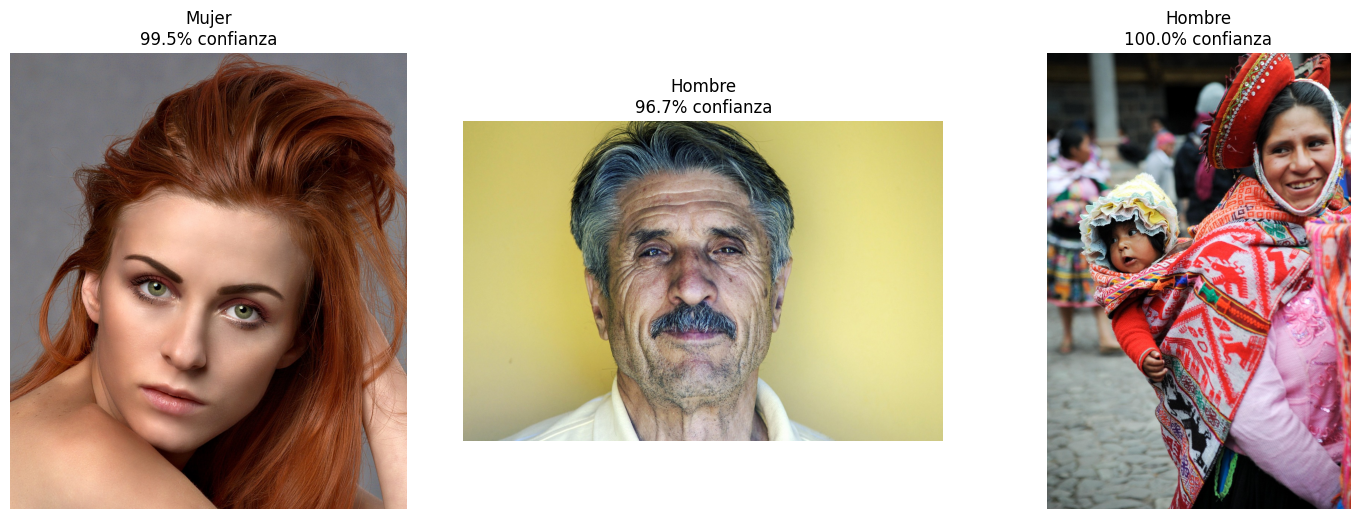

In [5]:
def show_predictions(folder_path, results, max_images=6):
    """
    Muestra las imágenes con sus predicciones
    """
    plt.figure(figsize=(15, 10))
    
    # Mostrar solo las primeras max_images
    display_results = results[:max_images] if results else []
    
    for i, result in enumerate(display_results):
        image_path = os.path.join(folder_path, result['archivo'])
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.subplot(2, 3, i + 1)
        plt.imshow(image_rgb)
        plt.title(f"{result['genero']}\n{result['confianza']:.1f}% confianza")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Mostrar resultados si existen
if 'results' in locals() and results:
    show_predictions("./images/", results)